# show reconstruct image

In [84]:
import pickle
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

In [85]:
with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

#log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
#logger = com.setup_logger(log_folder, '00_train.py')

In [86]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
os.makedirs(PKL_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)

In [87]:
with open('{}/{}_history.pkl'.format(PKL_DIR, 'ToyCar'), 'rb') as file:
    history = pickle.load(file)

In [88]:
history['reconstruct_img']['input'][0].shape

torch.Size([20, 64, 512, 1])

In [95]:
epoch_num = 6 # * 10

In [96]:
input_img = history['reconstruct_img']['input'][epoch_num][4,:,:,0].to('cpu')
output_img = history['reconstruct_img']['output'][epoch_num][4,:,:,0].to('cpu')

In [97]:
input_img.shape

torch.Size([64, 512])

In [98]:
np.array(F.mse_loss(output_img, input_img))

array(33.80174, dtype=float32)

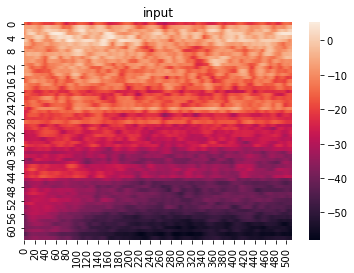

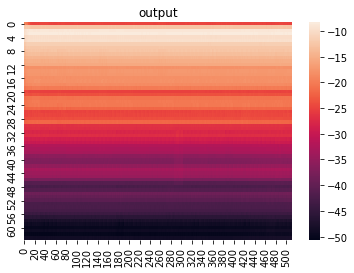

In [99]:
sns.heatmap(input_img)
plt.title('input')
plt.show()
sns.heatmap(output_img)
plt.title('output')
plt.show()

In [83]:
output_img

tensor([[-17.5560, -17.6066, -17.5134,  ..., -17.0085, -16.8527, -16.9035],
        [-17.6713, -17.5684, -17.8009,  ..., -16.9720, -17.0626, -17.0224],
        [-20.3701, -20.3661, -20.0139,  ..., -19.8626, -19.8229, -19.8145],
        ...,
        [-42.3483, -42.3740, -42.5447,  ..., -42.5175, -42.7558, -42.7751],
        [-42.6687, -42.6723, -42.5778,  ..., -42.4001, -42.6126, -42.5659],
        [-43.7381, -43.6961, -43.5973,  ..., -43.3525, -43.5720, -43.6110]])

In [100]:
output_img

tensor([[-19.4158, -19.3704, -19.1287,  ..., -24.8603, -24.8452, -24.8414],
        [-12.2769, -12.2205, -12.2736,  ..., -12.6565, -12.6197, -12.6270],
        [ -9.9135,  -9.8782,  -9.4404,  ...,  -8.8818,  -8.9110,  -8.9083],
        ...,
        [-49.0716, -49.0782, -49.0946,  ..., -48.4845, -48.4940, -48.5445],
        [-50.2058, -50.2486, -50.3789,  ..., -49.1996, -49.3007, -49.2931],
        [-48.6803, -48.6756, -48.7683,  ..., -47.8436, -47.8472, -47.8508]])

In [94]:
output_img

tensor([[-19.8486, -20.3218, -19.6627,  ..., -23.6687, -23.3266, -23.5955],
        [-12.7027, -12.8551, -12.7359,  ..., -13.6543, -13.7885, -12.9716],
        [-11.1233, -10.9864, -10.6981,  ...,  -9.0278,  -8.9579,  -9.0585],
        ...,
        [-49.2844, -49.2400, -49.4600,  ..., -49.1911, -49.0769, -49.1047],
        [-50.6545, -50.5509, -50.6621,  ..., -50.3541, -50.6165, -50.3913],
        [-49.4074, -49.2779, -49.6357,  ..., -49.4093, -49.3659, -49.4405]])

# eval

## import library

In [1]:
########################################################################
# import default python-library
########################################################################
import os
import glob
import csv
import re
import itertools
import sys
from collections import defaultdict
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy
from sklearn import metrics
import common as com
import pytorch_modeler as modeler
from pytorch_model import CNN6PANNsVAE as Model
import torch.utils.data
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import matplotlib.pyplot as plt
import seaborn as sns
########################################################################
import eval_functions as eval_func

## Setting

In [2]:
########################################################################
# load config
########################################################################
with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [3]:
########################################################################
# Setting seed
########################################################################
modeler.set_seed(42)

In [4]:
########################################################################
# Setting I/O path
########################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
eval_path = INPUT_ROOT + "/eval_test"
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
RESULT_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/result'
RECONS_OUTDIR = OUTPUT_ROOT +'/eval_reconstruct_img'
os.makedirs(MODEL_DIR, exist_ok=True)

In [5]:
########################################################################
# for original function
########################################################################
param = {}
param["dev_directory"] = dev_path
param["eval_directory"] = eval_path
param["model_directory"] = MODEL_DIR
param["result_directory"] = RESULT_DIR
param["result_file"] = 'result.csv'

## run eval

In [6]:
def make_reconstruct_img(x, y, label, file_name):
    fig = plt.figure(figsize=(10,5)) # width, height
    fig.suptitle('label={}'.format(int(label)))
    ax1 = fig.add_subplot(121, title='x') # 明示的にAxesを作成する
    sns.heatmap(x, ax=ax1) # ax1を参照するようにする
    ax2 = fig.add_subplot(122, title='y')
    sns.heatmap(y, ax=ax2)
    fig.savefig('{}.png'.format(file_name))

In [7]:
mode = 'dev'

2020-10-18 22:12:51,003 - INFO - load_directory <- development
2020-10-18 22:12:51,005 - INFO - ===========================
2020-10-18 22:12:51,006 - INFO - [1/6] /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/ToyCar
2020-10-18 22:12:51,006 - INFO - ============== MODEL LOAD ==============
2020-10-18 22:12:52,660 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/ToyCar_id_01
2020-10-18 22:12:52,668 - INFO - test_file  num : 601
2020-10-18 22:12:52,669 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============


2020-10-18 22:13:06,558 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_ToyCar_id_01.csv
2020-10-18 22:13:06,563 - INFO - AUC : 0.4887877063175867
2020-10-18 22:13:06,563 - INFO - pAUC : 0.5110085971901867
2020-10-18 22:13:06,564 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:13:06,565 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/ToyCar_id_02
2020-10-18 22:13:06,572 - INFO - test_file  num : 602
2020-10-18 22:13:06,573 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============


2020-10-18 22:13:20,437 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_ToyCar_id_02.csv
2020-10-18 22:13:20,440 - INFO - AUC : 0.49241496598639456
2020-10-18 22:13:20,440 - INFO - pAUC : 0.5105024465926722
2020-10-18 22:13:20,442 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:13:20,442 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/ToyCar_id_03
2020-10-18 22:13:20,449 - INFO - test_file  num : 602
2020-10-18 22:13:20,451 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============


2020-10-18 22:13:33,994 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_ToyCar_id_03.csv
2020-10-18 22:13:33,997 - INFO - AUC : 0.4873582766439909
2020-10-18 22:13:33,998 - INFO - pAUC : 0.508234872896527
2020-10-18 22:13:33,998 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:13:33,999 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/ToyCar_id_04
2020-10-18 22:13:34,007 - INFO - test_file  num : 602
2020-10-18 22:13:34,007 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============


2020-10-18 22:13:47,426 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_ToyCar_id_04.csv
2020-10-18 22:13:47,429 - INFO - AUC : 0.4859750566893424
2020-10-18 22:13:47,429 - INFO - pAUC : 0.5087122568325576
2020-10-18 22:13:47,430 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:13:47,431 - INFO - ===========================
2020-10-18 22:13:47,431 - INFO - [2/6] /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/ToyConveyor
2020-10-18 22:13:47,432 - INFO - ============== MODEL LOAD ==============
2020-10-18 22:13:48,021 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/ToyConveyor_id_01
2020-10-18 22:13:48,031 - INFO - test_file  num : 1181
2020-10-18 22:13:48,032 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============


2020-10-18 22:14:11,262 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_ToyConveyor_id_01.csv
2020-10-18 22:14:11,267 - INFO - AUC : 0.5106988188976379
2020-10-18 22:14:11,268 - INFO - pAUC : 0.49815236911175576
2020-10-18 22:14:11,268 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:14:11,269 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/ToyConveyor_id_02
2020-10-18 22:14:11,281 - INFO - test_file  num : 1136
2020-10-18 22:14:11,283 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:14:33,697 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_ToyConveyor_id_02.csv
2020-10-18 22:14:33,701 - INFO - AUC : 0.541264880952381
2020-10-18 22:14:33,701 - INFO - pAUC : 0.5029566102756892
2020-10-18 22:14:33,702 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:14:33,702 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/ToyConveyor_id_03
2020-10-18 22:14:33,713 - INFO - test_file  num : 1135
2020-10-18 22:14:33,714 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:14:56,061 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_ToyConveyor_id_03.csv
2020-10-18 22:14:56,065 - INFO - AUC : 0.555260668097026
2020-10-18 22:14:56,065 - INFO - pAUC : 0.5040420983623013
2020-10-18 22:14:56,066 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:14:56,066 - INFO - ===========================
2020-10-18 22:14:56,067 - INFO - [3/6] /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/fan
2020-10-18 22:14:56,067 - INFO - ============== MODEL LOAD ==============
2020-10-18 22:14:57,033 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/fan_id_00
2020-10-18 22:14:57,038 - INFO - test_file  num : 489
2020-10-18 22:14:57,039 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been o

2020-10-18 22:15:07,880 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_fan_id_00.csv
2020-10-18 22:15:07,884 - INFO - AUC : 0.4704627249357326
2020-10-18 22:15:07,885 - INFO - pAUC : 0.4951968610472196
2020-10-18 22:15:07,885 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:15:07,886 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/fan_id_02
2020-10-18 22:15:07,892 - INFO - test_file  num : 441
2020-10-18 22:15:07,893 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:15:17,910 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_fan_id_02.csv
2020-10-18 22:15:17,914 - INFO - AUC : 0.5855718475073313
2020-10-18 22:15:17,915 - INFO - pAUC : 0.5594999228275969
2020-10-18 22:15:17,915 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:15:17,916 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/fan_id_04
2020-10-18 22:15:17,921 - INFO - test_file  num : 430
2020-10-18 22:15:17,921 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:15:28,138 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_fan_id_04.csv
2020-10-18 22:15:28,141 - INFO - AUC : 0.4488181818181818
2020-10-18 22:15:28,141 - INFO - pAUC : 0.4977671451355662
2020-10-18 22:15:28,142 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:15:28,142 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/fan_id_06
2020-10-18 22:15:28,148 - INFO - test_file  num : 443
2020-10-18 22:15:28,148 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:15:38,602 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_fan_id_06.csv
2020-10-18 22:15:38,605 - INFO - AUC : 0.5338192419825073
2020-10-18 22:15:38,605 - INFO - pAUC : 0.5049869571888906
2020-10-18 22:15:38,606 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:15:38,607 - INFO - ===========================
2020-10-18 22:15:38,608 - INFO - [4/6] /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/pump
2020-10-18 22:15:38,608 - INFO - ============== MODEL LOAD ==============
2020-10-18 22:15:39,651 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/pump_id_00
2020-10-18 22:15:39,654 - INFO - test_file  num : 237
2020-10-18 22:15:39,655 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened

2020-10-18 22:15:46,208 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_pump_id_00.csv
2020-10-18 22:15:46,211 - INFO - AUC : 0.7475912408759124
2020-10-18 22:15:46,212 - INFO - pAUC : 0.5954667691125625
2020-10-18 22:15:46,213 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:15:46,213 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/pump_id_02
2020-10-18 22:15:46,216 - INFO - test_file  num : 205
2020-10-18 22:15:46,217 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:15:52,046 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_pump_id_02.csv
2020-10-18 22:15:52,049 - INFO - AUC : 0.648
2020-10-18 22:15:52,050 - INFO - pAUC : 0.5719298245614035
2020-10-18 22:15:52,050 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:15:52,051 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/pump_id_04
2020-10-18 22:15:52,054 - INFO - test_file  num : 194
2020-10-18 22:15:52,055 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:15:58,200 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_pump_id_04.csv
2020-10-18 22:15:58,203 - INFO - AUC : 0.5882978723404255
2020-10-18 22:15:58,204 - INFO - pAUC : 0.5195968645016797
2020-10-18 22:15:58,204 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:15:58,205 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/pump_id_06
2020-10-18 22:15:58,209 - INFO - test_file  num : 196
2020-10-18 22:15:58,210 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:16:04,011 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_pump_id_06.csv
2020-10-18 22:16:04,014 - INFO - AUC : 0.5086458333333334
2020-10-18 22:16:04,015 - INFO - pAUC : 0.48903508771929827
2020-10-18 22:16:04,015 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:16:04,015 - INFO - ===========================
2020-10-18 22:16:04,016 - INFO - [5/6] /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/slider
2020-10-18 22:16:04,017 - INFO - ============== MODEL LOAD ==============
2020-10-18 22:16:04,995 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/slider_id_00
2020-10-18 22:16:04,999 - INFO - test_file  num : 445
2020-10-18 22:16:05,000 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been 

2020-10-18 22:16:15,071 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_slider_id_00.csv
2020-10-18 22:16:15,075 - INFO - AUC : 0.8082028985507246
2020-10-18 22:16:15,075 - INFO - pAUC : 0.4973302822273074
2020-10-18 22:16:15,076 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:16:15,076 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/slider_id_02
2020-10-18 22:16:15,081 - INFO - test_file  num : 356
2020-10-18 22:16:15,081 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:16:23,644 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_slider_id_02.csv
2020-10-18 22:16:23,648 - INFO - AUC : 0.5962500000000001
2020-10-18 22:16:23,648 - INFO - pAUC : 0.49979440789473684
2020-10-18 22:16:23,649 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:16:23,649 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/slider_id_04
2020-10-18 22:16:23,653 - INFO - test_file  num : 267
2020-10-18 22:16:23,654 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:16:31,239 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_slider_id_04.csv
2020-10-18 22:16:31,243 - INFO - AUC : 0.579820359281437
2020-10-18 22:16:31,245 - INFO - pAUC : 0.5222187204538292
2020-10-18 22:16:31,245 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:16:31,246 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/slider_id_06
2020-10-18 22:16:31,250 - INFO - test_file  num : 178
2020-10-18 22:16:31,251 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:16:36,891 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_slider_id_06.csv
2020-10-18 22:16:36,895 - INFO - AUC : 0.41102564102564104
2020-10-18 22:16:36,895 - INFO - pAUC : 0.4817813765182186
2020-10-18 22:16:36,896 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:16:36,897 - INFO - ===========================
2020-10-18 22:16:36,897 - INFO - [6/6] /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/valve
2020-10-18 22:16:36,898 - INFO - ============== MODEL LOAD ==============
2020-10-18 22:16:37,384 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/valve_id_00
2020-10-18 22:16:37,387 - INFO - test_file  num : 213
2020-10-18 22:16:37,388 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been 

2020-10-18 22:16:43,621 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_valve_id_00.csv
2020-10-18 22:16:43,624 - INFO - AUC : 0.4009734513274337
2020-10-18 22:16:43,625 - INFO - pAUC : 0.504424778761062
2020-10-18 22:16:43,625 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:16:43,626 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/valve_id_02
2020-10-18 22:16:43,629 - INFO - test_file  num : 214
2020-10-18 22:16:43,630 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:16:49,679 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_valve_id_02.csv
2020-10-18 22:16:49,682 - INFO - AUC : 0.5673684210526315
2020-10-18 22:16:49,683 - INFO - pAUC : 0.4995383194829178
2020-10-18 22:16:49,683 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:16:49,684 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/valve_id_04
2020-10-18 22:16:49,686 - INFO - test_file  num : 214
2020-10-18 22:16:49,687 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:16:56,089 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_valve_id_04.csv
2020-10-18 22:16:56,092 - INFO - AUC : 0.5312280701754386
2020-10-18 22:16:56,093 - INFO - pAUC : 0.5147737765466297
2020-10-18 22:16:56,093 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:16:56,094 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/valve_id_06
2020-10-18 22:16:56,098 - INFO - test_file  num : 214
2020-10-18 22:16:56,098 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


2020-10-18 22:17:02,052 - INFO - anomaly score result ->  /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/anomaly_score_valve_id_06.csv
2020-10-18 22:17:02,055 - INFO - AUC : 0.43701754385964914
2020-10-18 22:17:02,056 - INFO - pAUC : 0.49769159741458907
2020-10-18 22:17:02,056 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2020-10-18 22:17:02,057 - INFO - AUC and pAUC results -> /media/hiroki/working/research/dcase2020/result/2D/CONV_VAE/result/result.csv


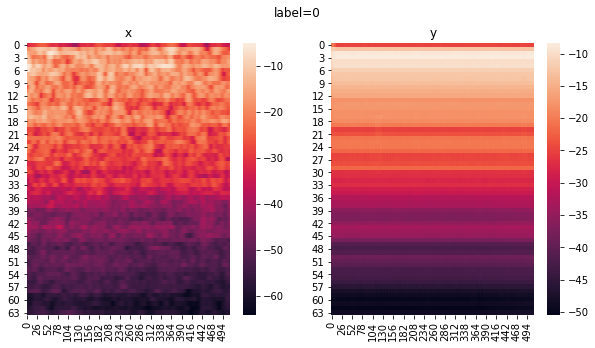

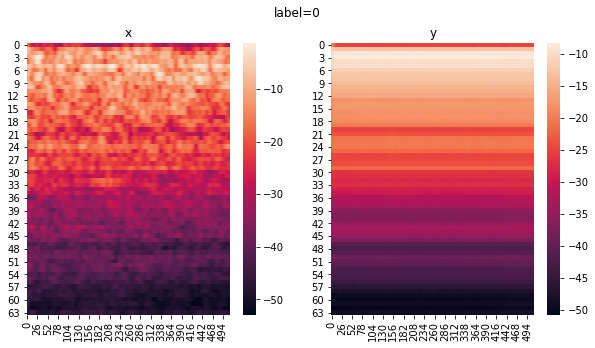

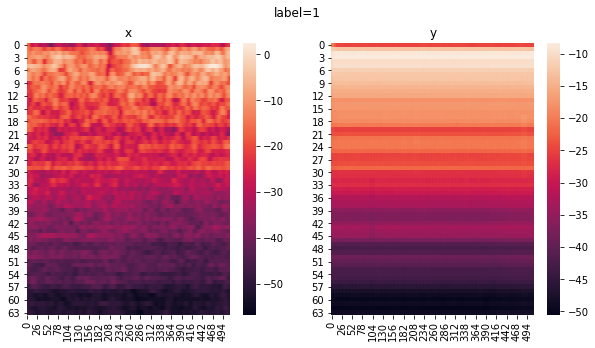

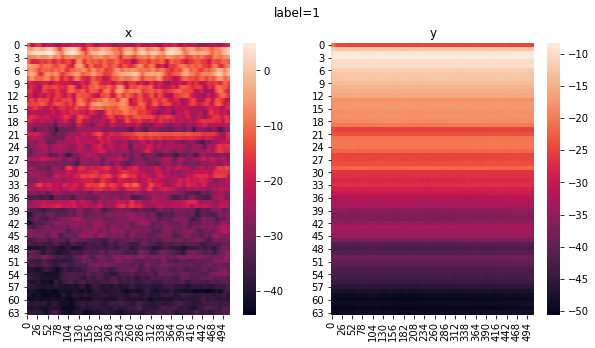

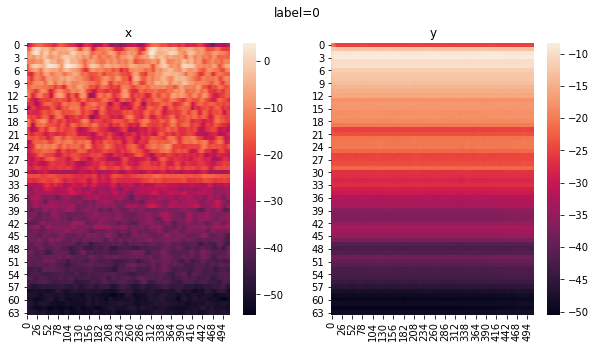

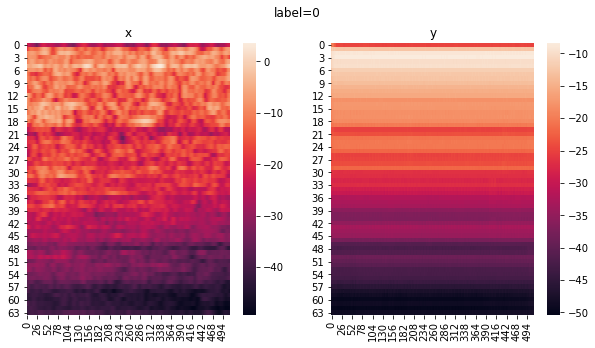

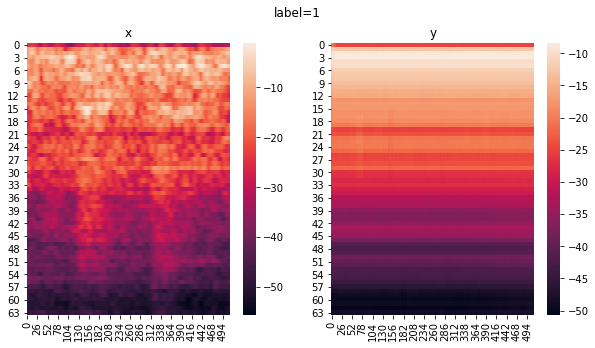

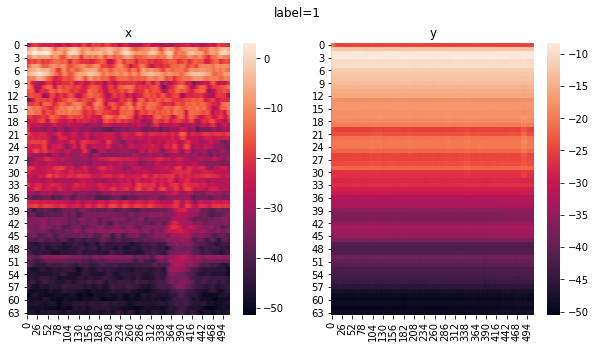

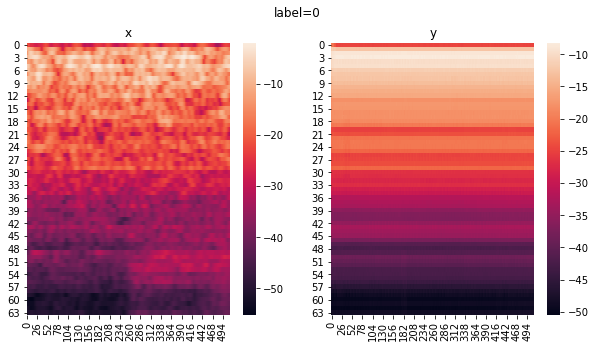

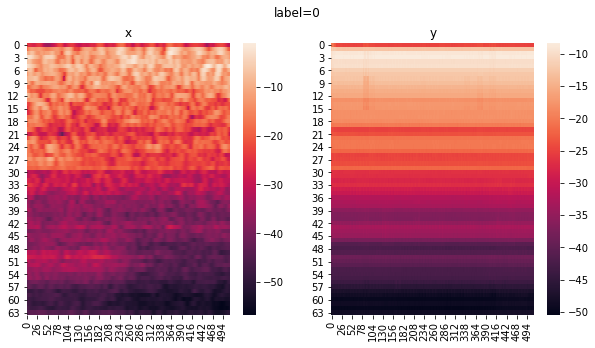

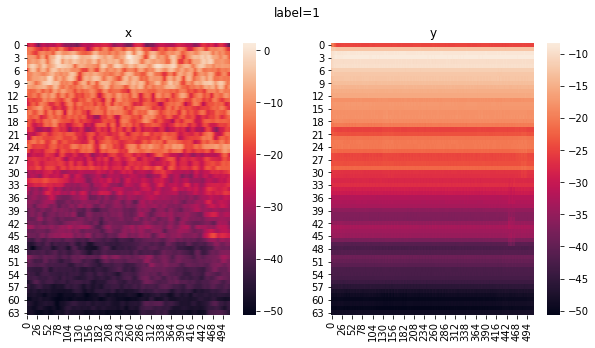

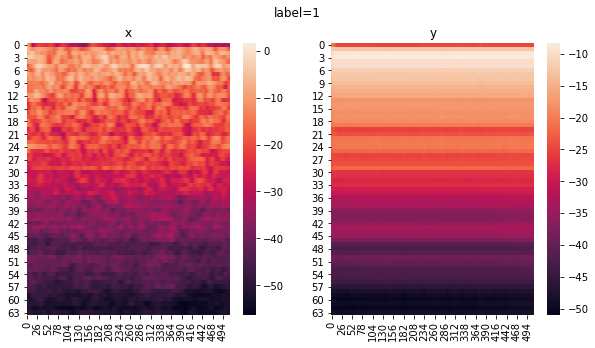

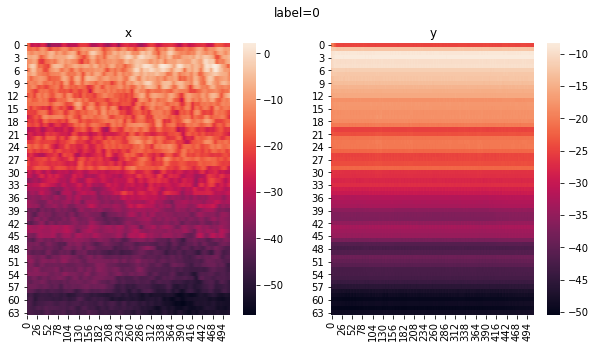

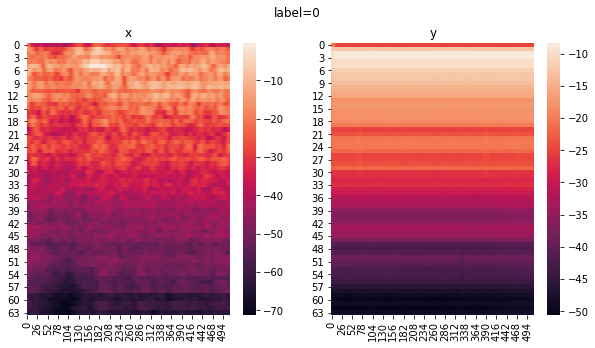

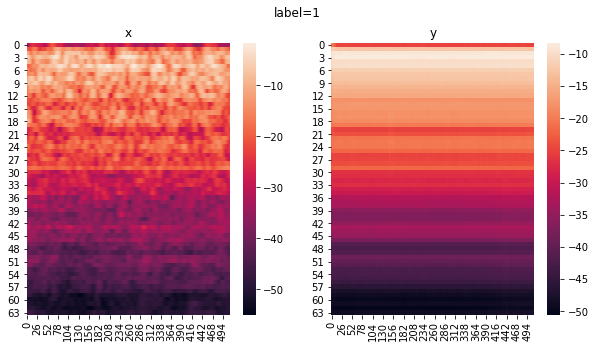

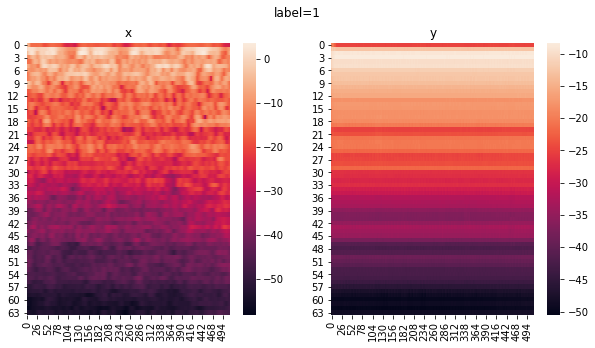

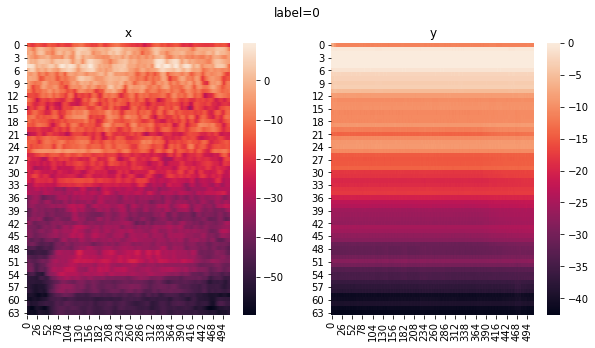

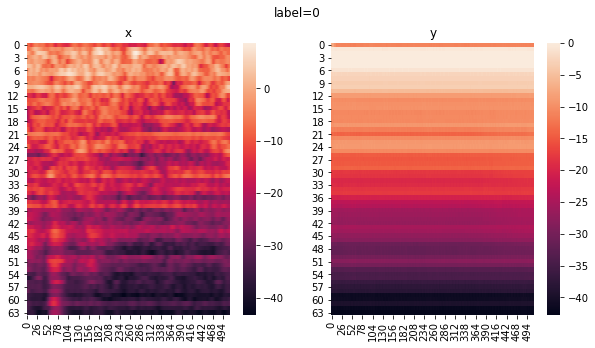

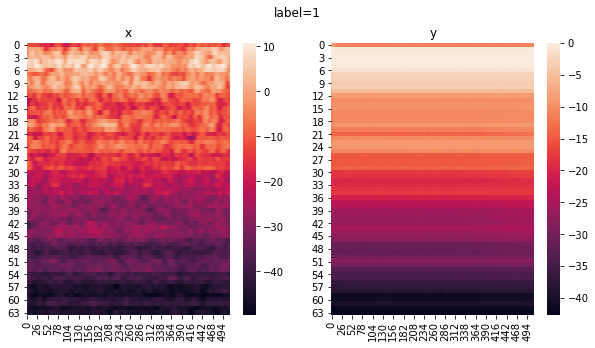

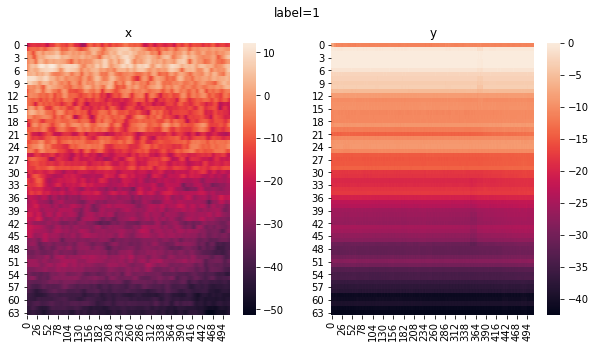

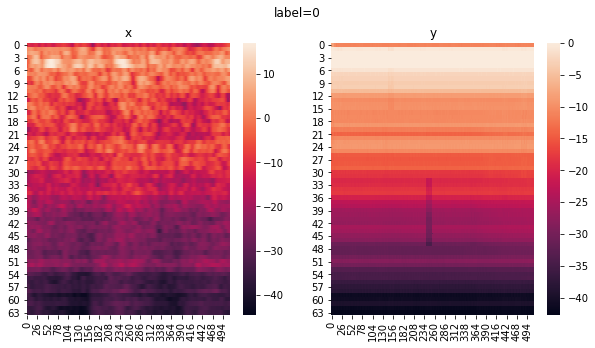

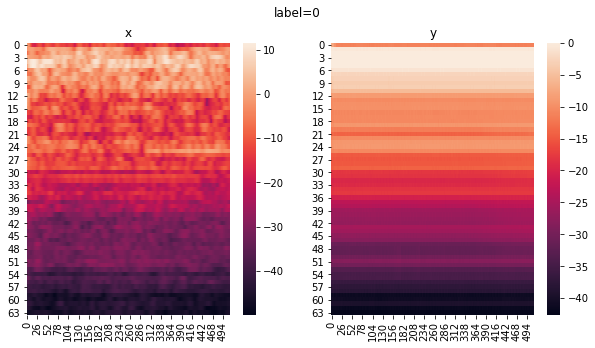

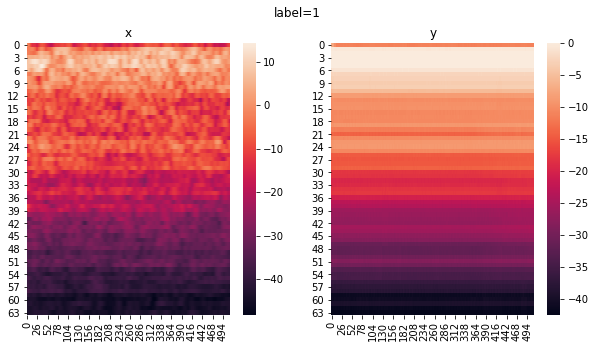

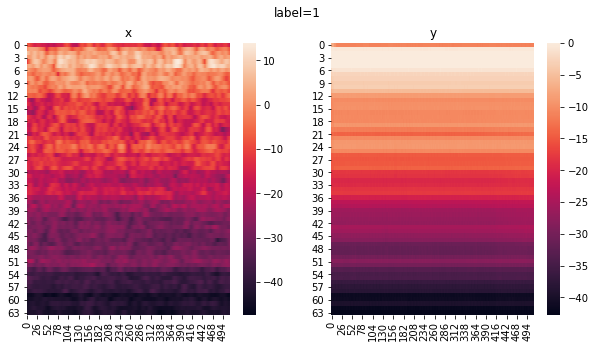

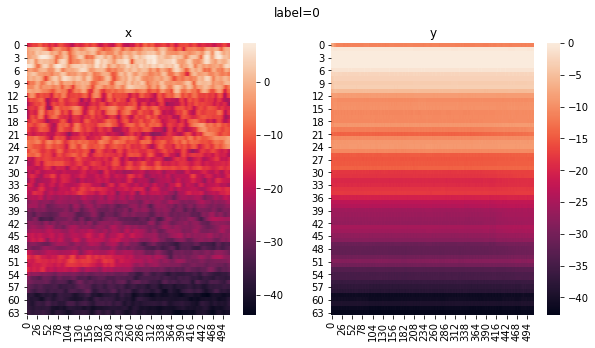

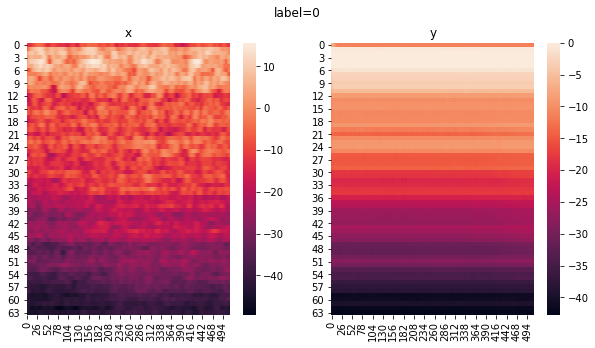

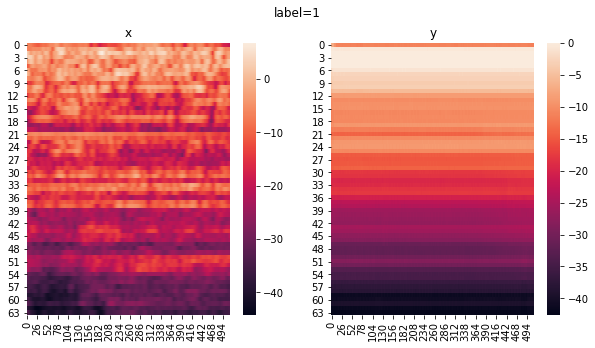

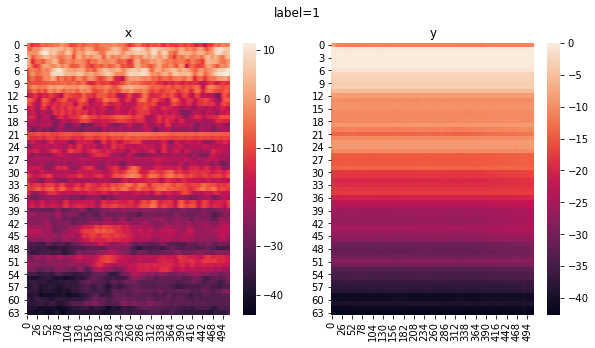

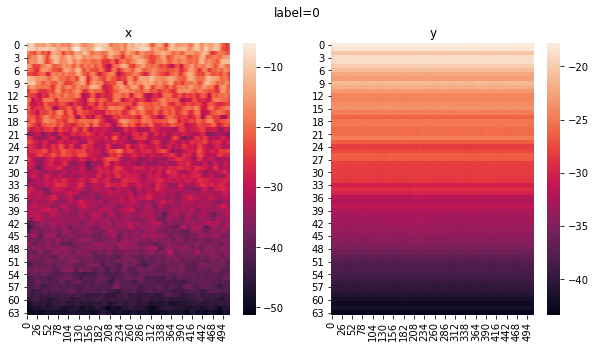

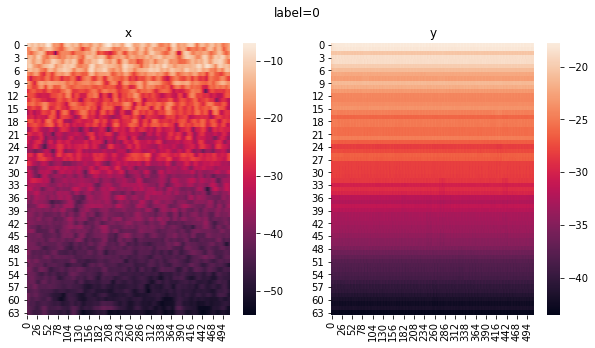

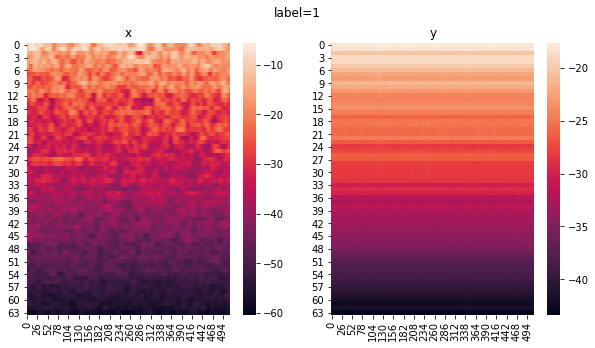

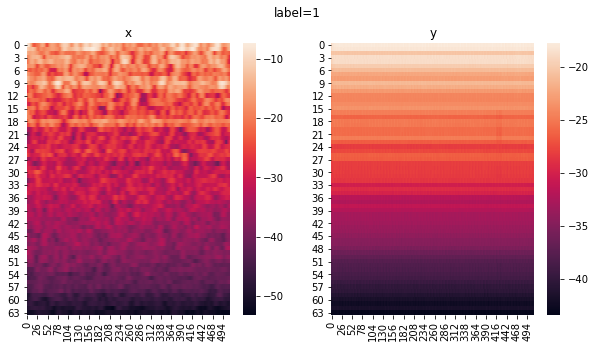

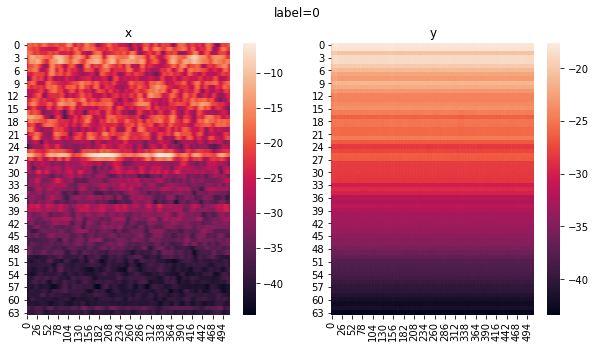

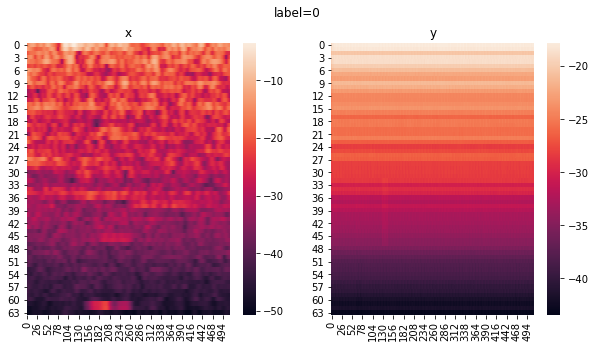

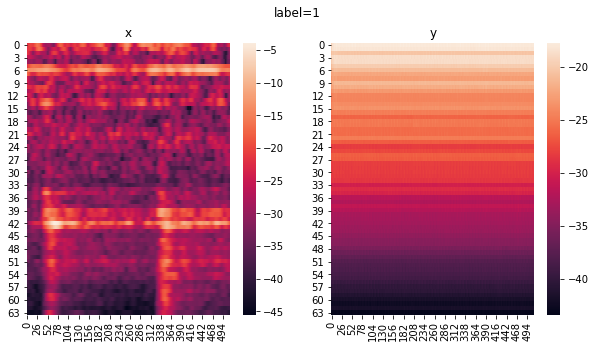

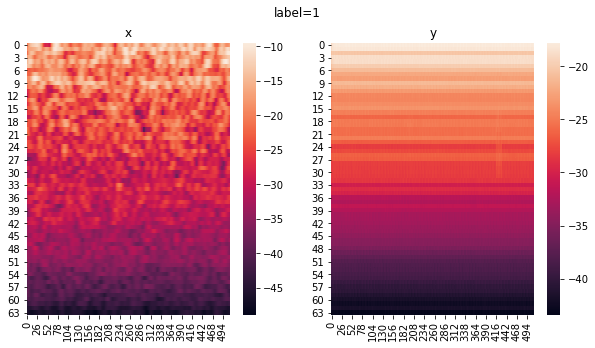

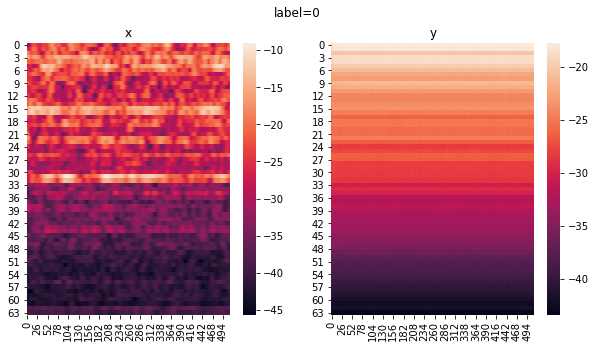

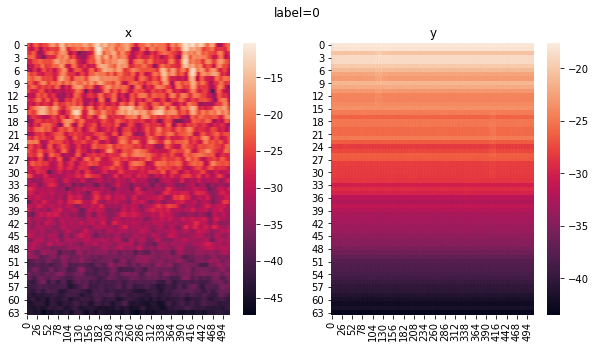

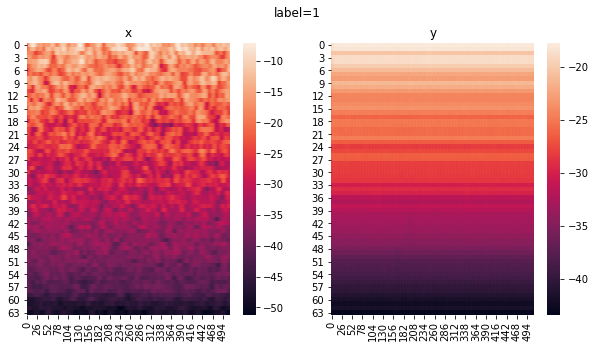

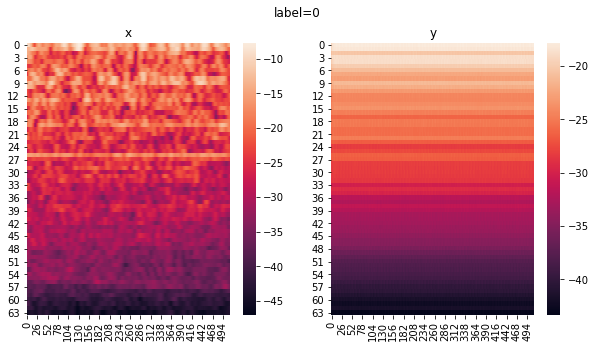

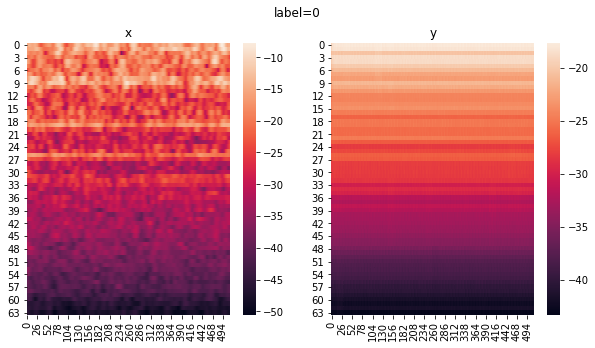

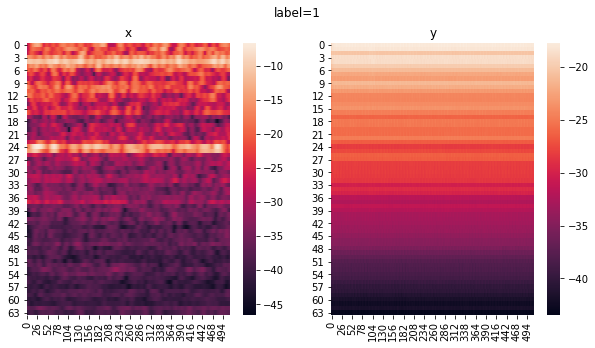

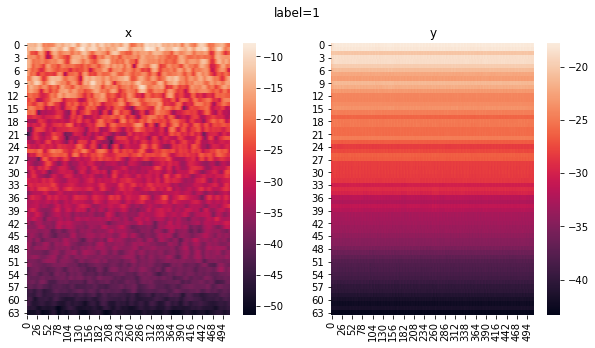

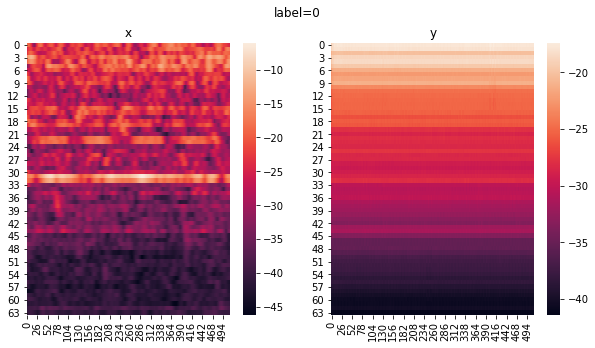

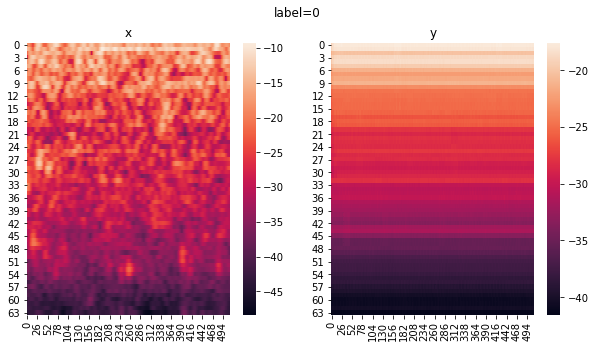

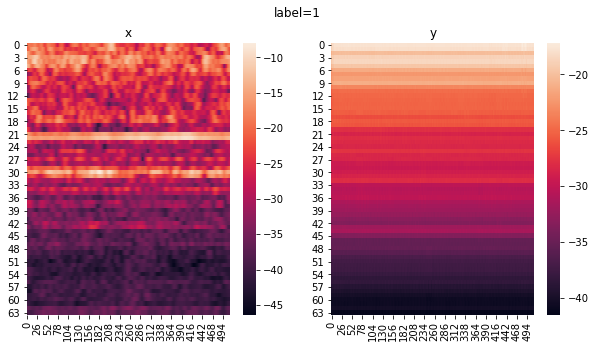

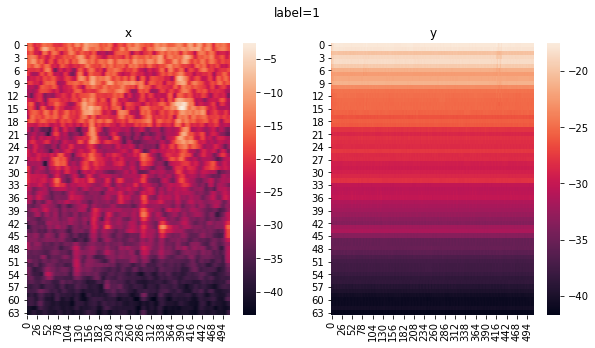

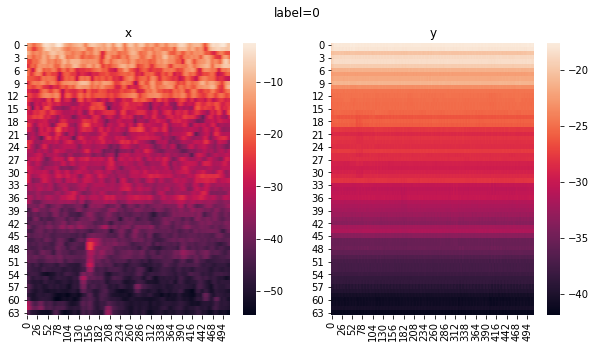

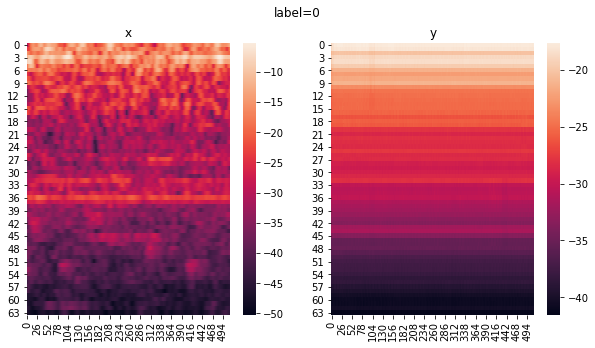

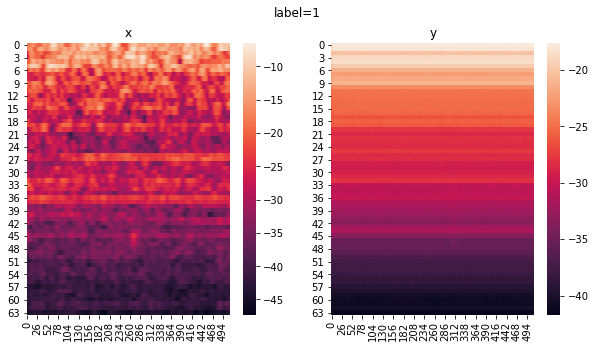

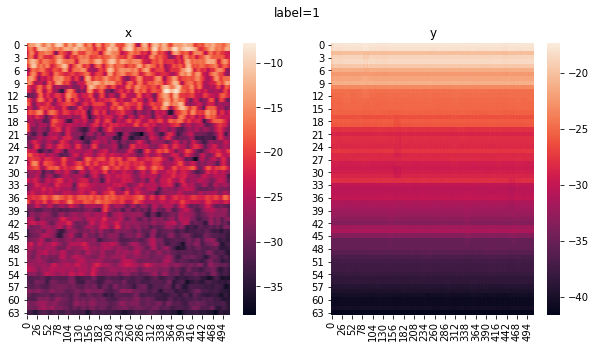

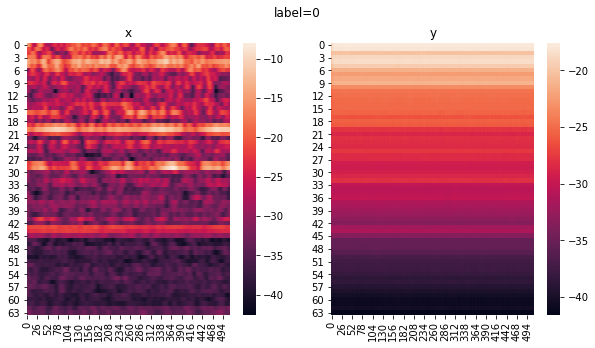

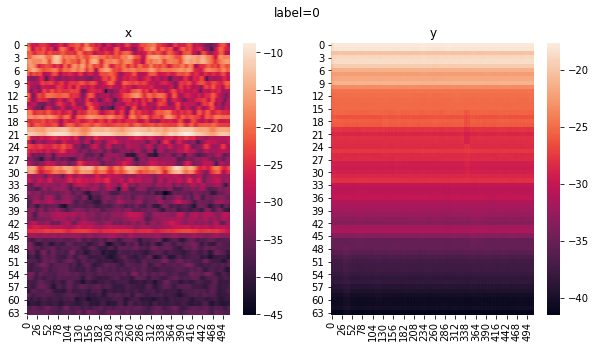

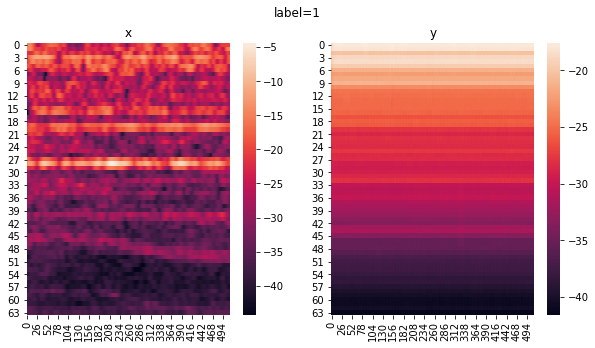

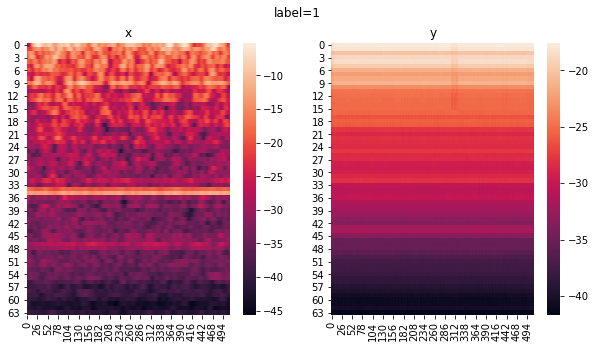

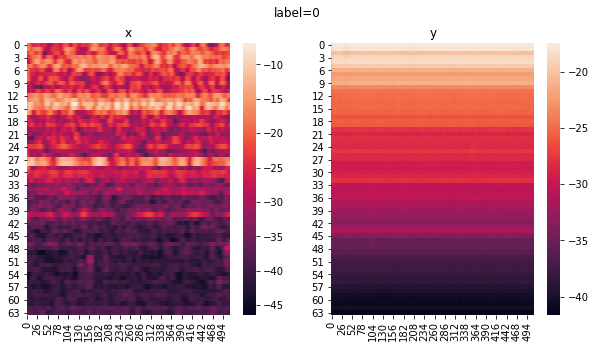

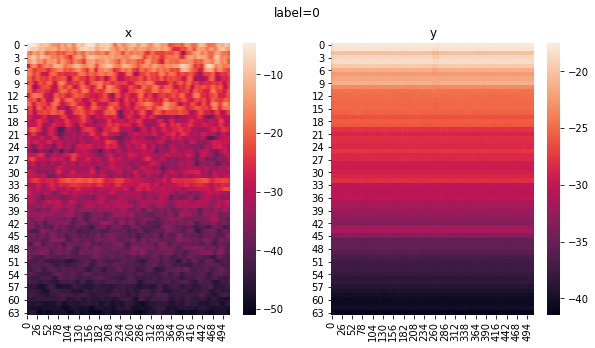

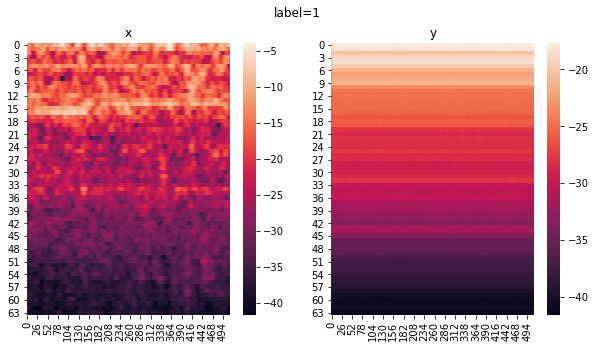

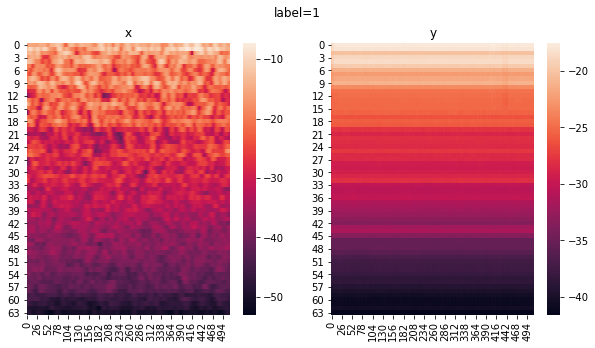

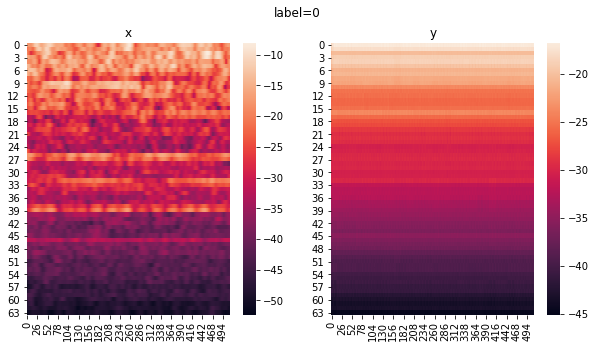

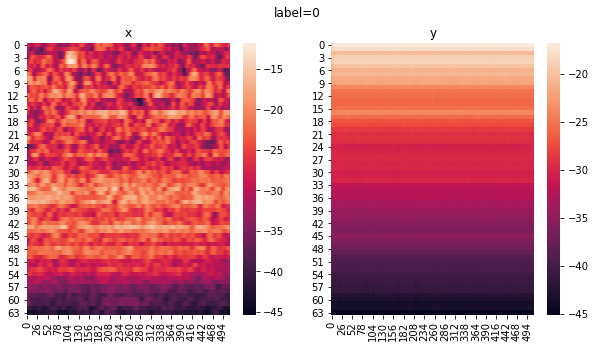

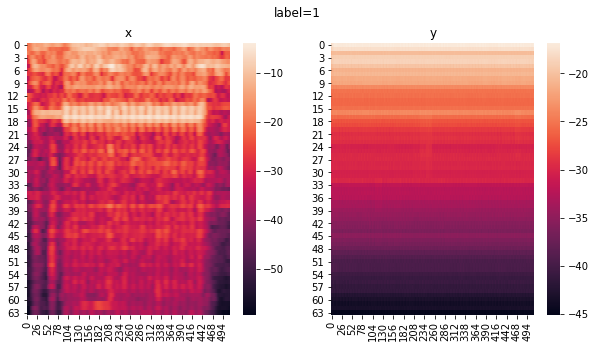

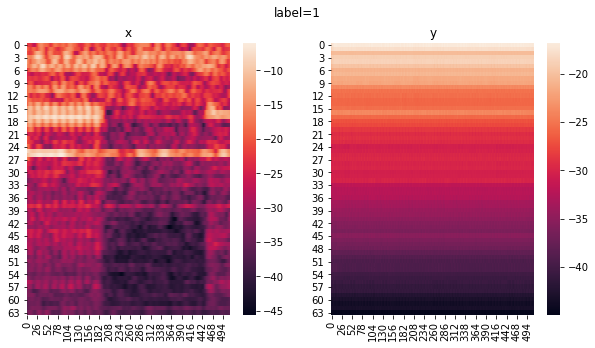

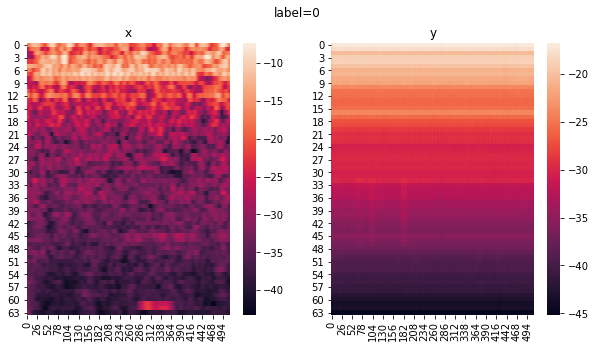

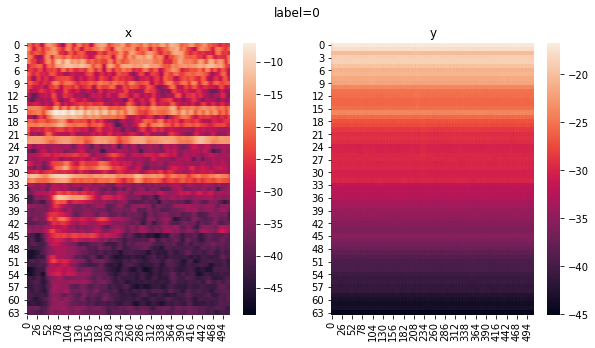

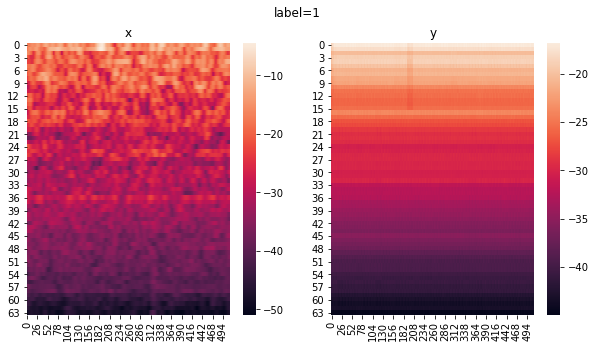

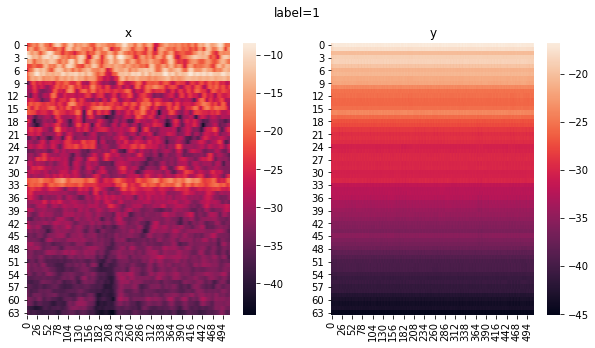

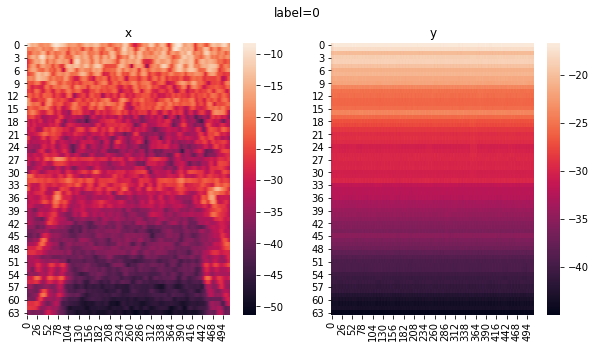

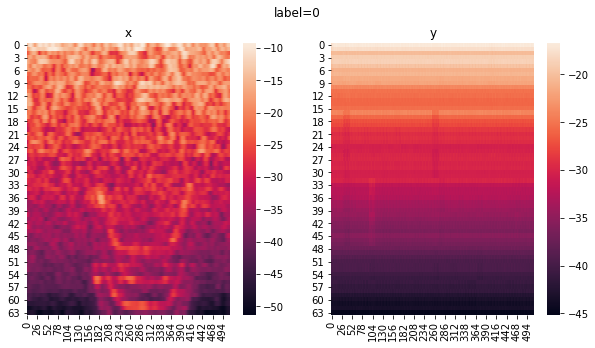

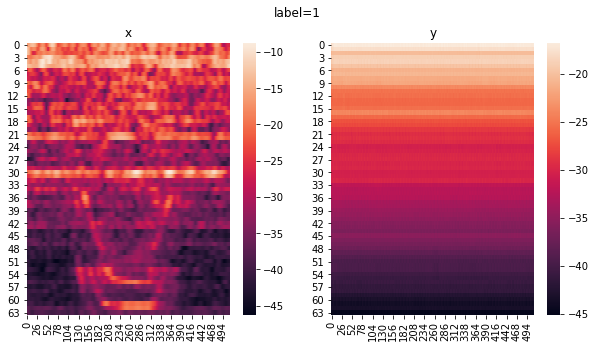

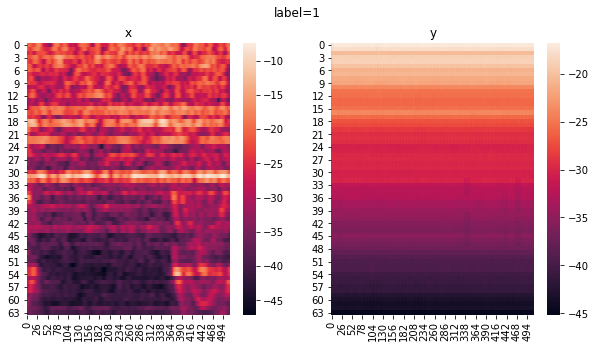

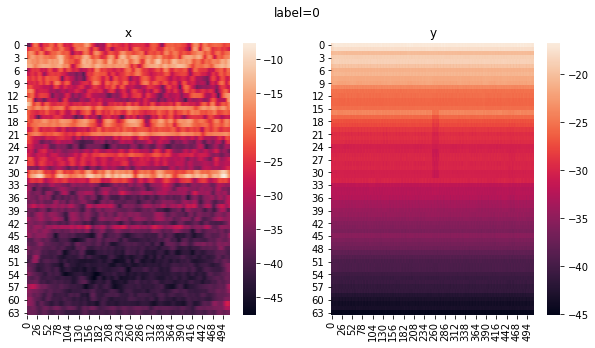

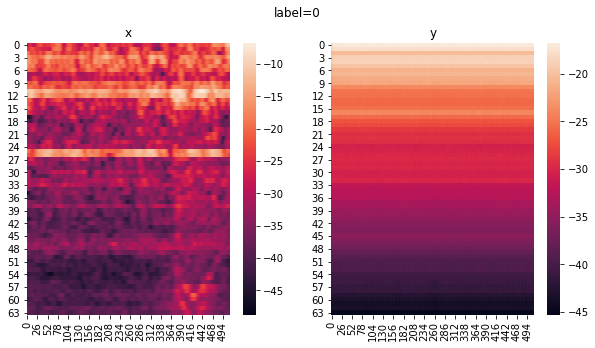

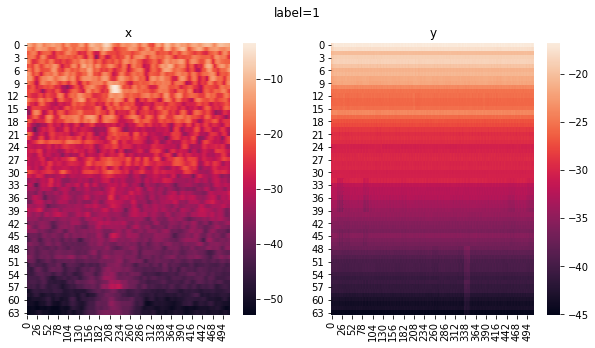

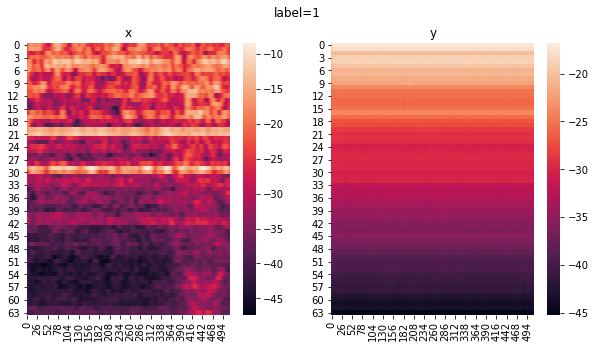

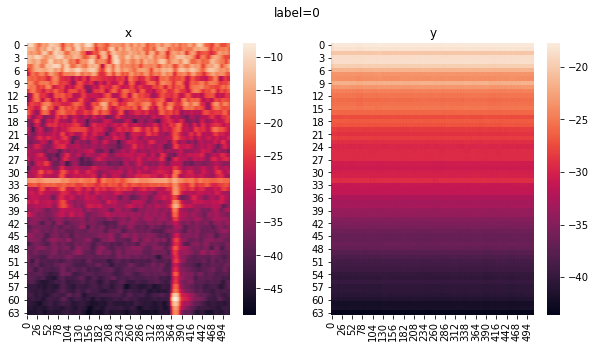

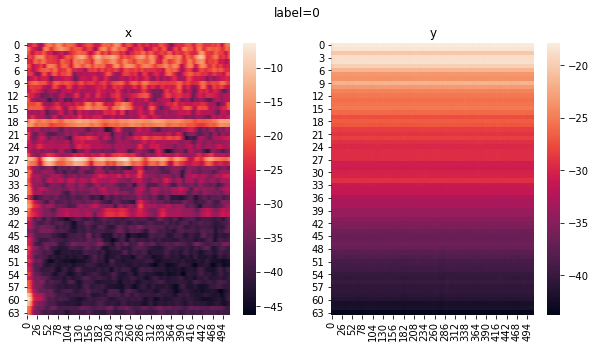

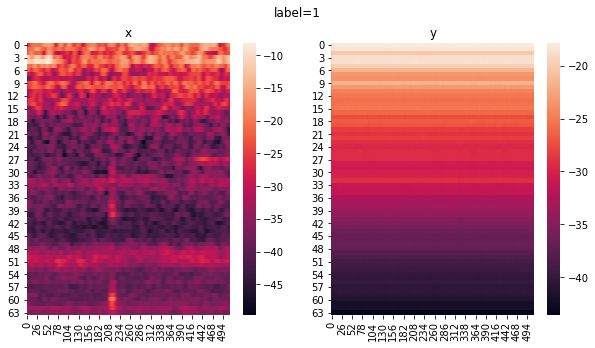

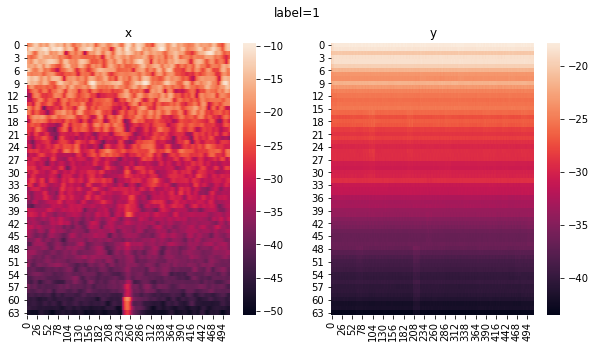

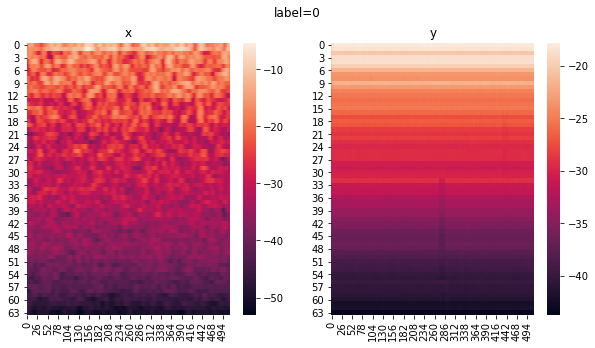

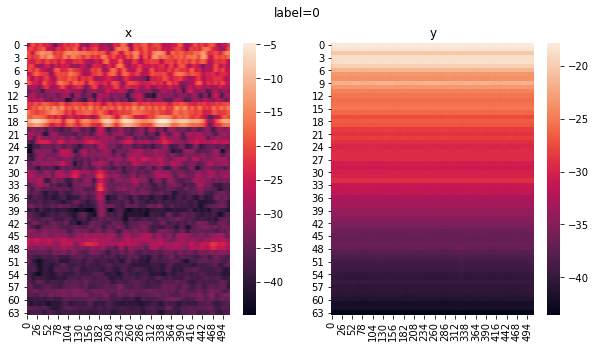

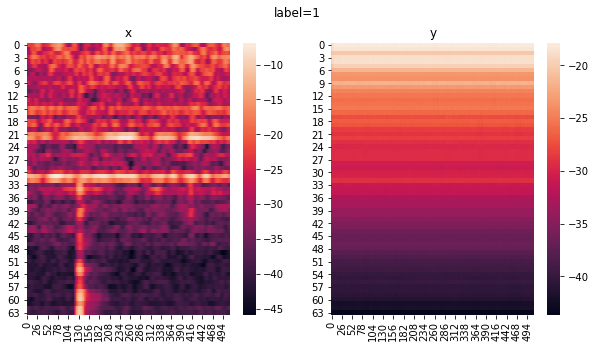

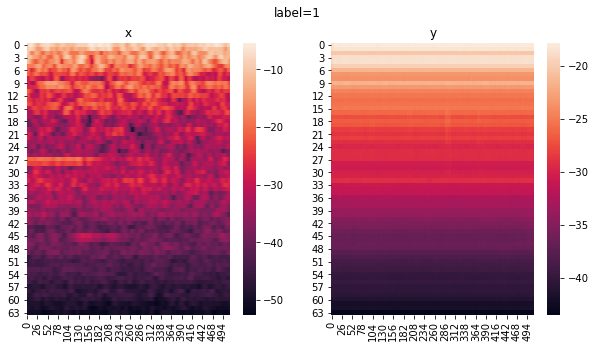

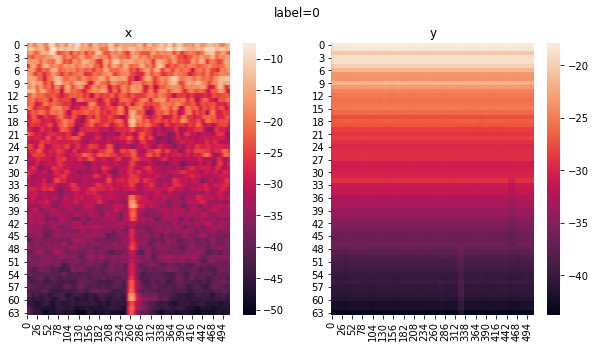

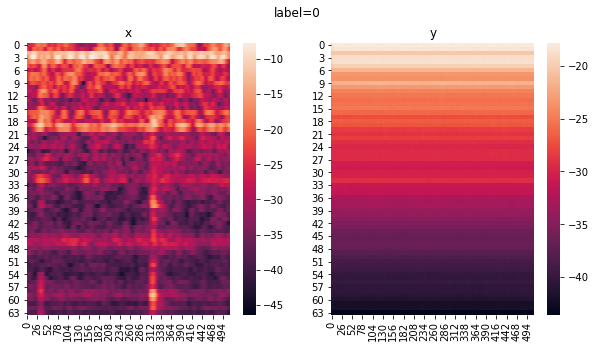

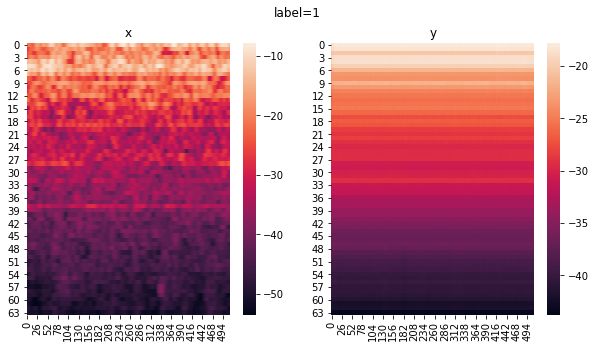

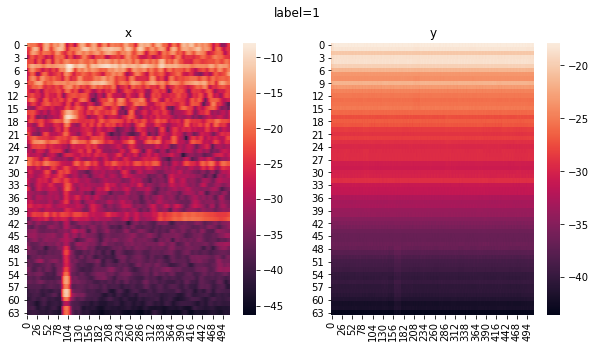

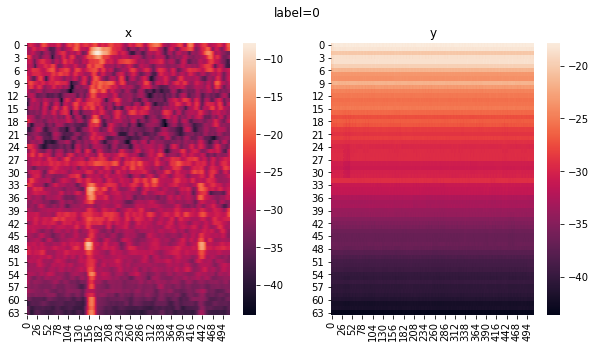

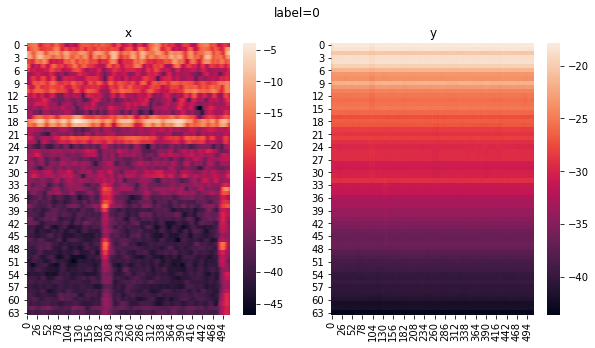

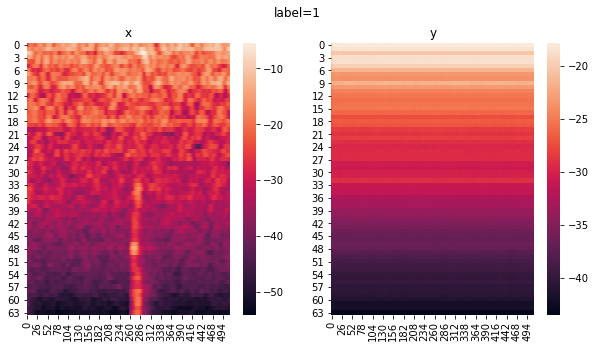

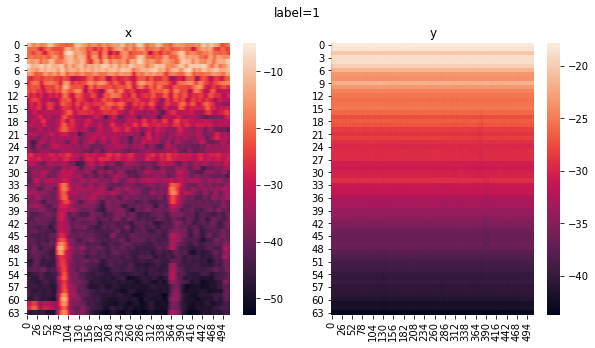

In [8]:
#def run_eval(param, mode):
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# make output result directory
os.makedirs(RESULT_DIR, exist_ok=True)

# load base directory
dirs = com.select_dirs(param=param, mode=mode)

# initialize lines in csv for AUC and pAUC
csv_lines = []


# loop of the base directory
for idx, target_dir in enumerate(dirs):
    com.logger.info("===========================")
    com.logger.info("[{idx}/{total}] {dirname}".format(
        dirname=target_dir, idx=idx+1, total=len(dirs)))

    machine_type = os.path.split(target_dir)[1]

    com.logger.info("============== MODEL LOAD ==============")

    model_file = "{model}/{machine_type}_model.pth".format(
        model=param["model_directory"],
        machine_type=machine_type)

    if not os.path.exists(model_file):
        com.logger.error("{} model not found ".format(machine_type))
        sys.exit(-1)

    # define AE model
    model = Model(sample_rate=config['preprocessing']['sample_rate'],
                  window_size=config['preprocessing']['window_size'],
                  hop_size=config['preprocessing']['hop_size'],
                  mel_bins=config['preprocessing']['mel_bins'],
                  fmin=config['preprocessing']['fmin'],
                  fmax=config['preprocessing']['fmax']).to(device)
    model.eval()
    model.load_state_dict(torch.load(model_file))

    if mode:
        # results by type
        csv_lines.append([machine_type])
        csv_lines.append(["id", "AUC", "pAUC"])
        performance = []

    machine_id_list = eval_func.get_machine_id_list_for_test(target_dir)
    recons_outpath = RECONS_OUTDIR + '/' + machine_type
    os.makedirs(recons_outpath, exist_ok=True)
    for id_str in machine_id_list:

        # load list of test files
        test_files, y_true = eval_func.test_file_list_generator(target_dir, id_str, mode)

        # setup anomaly score file path
        anomaly_score_csv = \
            "{result}/anomaly_score_{machine_type}_{id_str}.csv"\
            .format(result=param["result_directory"],
                    machine_type=machine_type,
                    id_str=id_str)
        anomaly_score_list = []

        com.logger.info(
            "============== BEGIN TEST FOR A MACHINE ID ==============")

        y_pred = [0. for k in test_files]
        anomaly_count = 0
        normal_count = 0
        for file_idx, file_path in enumerate(test_files):
            try:
                data = com.file_load(file_path)
                data = data[0]
                # reconstruction through auto encoder in pytorch
                input_data = torch.from_numpy(data).float().to(device)
                input_data = input_data.unsqueeze(0)
                with torch.no_grad():
                    output_dict = model(input_data, device)
                    pred = output_dict['loss'].to('cpu').detach().numpy().copy()
                    # make reconstruct_img
                    x = output_dict['x'].to('cpu')[0,:,:,0]
                    y = output_dict['y'].to('cpu')[0,:,:,0]
                    label = y_true[file_idx]
                    file_name = os.path.basename(file_path).replace('.wav', '')
                    file_name = recons_outpath + '/' + file_name
                    if int(label) == 1:
                        if anomaly_count == 1 or anomaly_count == 2:
                            make_reconstruct_img(x, y, label, file_name)
                        anomaly_count+=1
                    else:
                        if normal_count == 1 or normal_count == 2:
                            make_reconstruct_img(x, y, label, file_name)
                        normal_count+=1
                    
                y_pred[file_idx] = pred
                anomaly_score_list.append(
                    [os.path.basename(file_path), y_pred[file_idx]])
            except FileNotFoundError:
                com.logger.error("file broken!!: {}".format(file_path))

        # save anomaly score
        eval_func.save_csv(save_file_path=anomaly_score_csv,
                           save_data=anomaly_score_list)
        com.logger.info(
            "anomaly score result ->  {}".format(anomaly_score_csv))

        if mode:
            # append AUC and pAUC to lists
            auc = metrics.roc_auc_score(y_true, y_pred)
            p_auc = metrics.roc_auc_score(
                y_true, y_pred, max_fpr=config["etc"]["max_fpr"])
            csv_lines.append([id_str.split("_", 1)[1], auc, p_auc])
            performance.append([auc, p_auc])
            com.logger.info("AUC : {}".format(auc))
            com.logger.info("pAUC : {}".format(p_auc))

        com.logger.info(
            "============ END OF TEST FOR A MACHINE ID ============")

    if mode:
        # calculate averages for AUCs and pAUCs
        averaged_performance = numpy.mean(
            numpy.array(performance, dtype=float), axis=0)
        csv_lines.append(["Average"] + list(averaged_performance))
        csv_lines.append([])

if mode:
    # output results
    result_path = "{result}/{file_name}".format(
        result=param["result_directory"],
        file_name=param["result_file"])
    com.logger.info("AUC and pAUC results -> {}".format(result_path))
    eval_func.save_csv(save_file_path=result_path, save_data=csv_lines)